# Demo 1: Autoencoder

This demo we will demo code for how to implement and train autoencoders and apply the autoencoder to solve the binary classification problem:

-   Binary Classification Problem: Surface defect binary classification (defect and non-defect)
-   Dataset:
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...) 

Tasks Outlines:
## 0. Task 0: Preparing dataset:
## 1. Task 1: Constructing autoencoder model by using TensorFlow library:
-   Constructing the Encoder component
-   Constructing the Decoder component
## 2. Task 2: Training model
-   Loss function
-   Optimizers
-   Augmentation
## 3. Task 3: Evaluating the performance of trained model
-   Perform trained model on test image
-   How to apply it for Surface Defect Binary Classification
*******************************************************************


## Import all packages

In [15]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn import metrics

## 0. Task 0: Preparing

### 0.1. Define a function get all paths to each image in the dataset for training

In [16]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.jpg')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    """
    list_img_paths = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
    return list_img_paths




### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [17]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             is_resize:bool = True,
             width:int = 28,
             height:int = 28,
             n_channel:int = 1) -> (np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if n_channel == 1:
            img = img.convert('L')
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return np.array(data)

### 0.3. Getting data by using two previouse function

In [19]:
# Get the list of all path to images, and the list of relative truth labels
dir_data_train = "/Users/user/Victor2023/Dataset/Dataset_heatsink/test/0"
list_img_paths = get_all_img_label_path(input_dir=dir_data_train,
                                                    img_suffix='.jpg')

width = 128
height = 128
n_channel = 1
X = get_data(list_img_paths=list_img_paths,
               is_resize=True,
               width=width,
               height=height,
               n_channel=n_channel)

# Get the total number of test samples we have:
n_samples = X.shape[0]
# Reshaping 
X = X.reshape(n_samples,height,width,1)
# Change type value and scaling value
X = X.astype('float32')
X /= 255.0
n_train = int(n_samples*80/100)
X_train = X[:n_train]
X_val = X[n_train:]

## 1. Task 1: Constructing Autoencoder Model

### 1.1. Define the encoder component

In [20]:
# Define the input shape
en_input = keras.layers.Input(shape=(height,width,n_channel)) 
encode = keras.layers.Conv2D(32,(5,5),activation="relu",padding='same')(en_input)
encode = keras.layers.MaxPool2D((2,2),padding="same")(encode)
encode = keras.layers.Conv2D(32,(3,3),activation="relu",padding="same")(encode)
encode = keras.layers.MaxPool2D((2,2),padding="same")(encode)
# Getting the shape under convolutional layers
conv_out_shape = keras.backend.int_shape(encode)
encode = keras.layers.Flatten()(encode)
encode = keras.layers.Dense(128,activation="relu")(encode)
en_output = keras.layers.Dense(32,activation="relu")(encode)

encoder_component = keras.Model(en_input,en_output,name="Encoder")

### 1.2. Define the decoder component

In [21]:
de_input = keras.layers.Input(shape=(32,))
decode = keras.layers.Dense(128,activation="relu")(de_input)
decode = keras.layers.Dense(np.prod(conv_out_shape[1:]))(decode)
decode = keras.layers.Reshape((conv_out_shape[1],conv_out_shape[2],conv_out_shape[3]))(decode)
decode = keras.layers.Conv2DTranspose(32,(3,3),
                                      strides=2,
                                      activation="relu",
                                      padding="same")(decode)
decode = keras.layers.Conv2DTranspose(32,(5,5),
                                      strides=2,
                                      activation="relu",
                                      padding="same")(decode)
de_output = keras.layers.Conv2D(1,(3,3),
                                activation="sigmoid",
                                padding="same")(decode)
decoder_component = keras.Model(de_input,de_output,name="Decoder")


### 1.3. Combine two components to obtain the autoencoder model

In [22]:
model_autoencoder = keras.Model(en_input,
                                decoder_component(encoder_component(en_input)),
                                name = "Autoencoder")

In [23]:
encoder_component.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0   

In [24]:
decoder_component.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_10 (Dense)            (None, 128)               4224      
                                                                 
 dense_11 (Dense)            (None, 32768)             4227072   
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 64, 64, 32)       9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 128, 128, 32)     25632     
 ranspose)                                                 

In [25]:
model_autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 Encoder (Functional)        (None, 32)                4208640   
                                                                 
 Decoder (Functional)        (None, 128, 128, 1)       4266465   
                                                                 
Total params: 8,475,105
Trainable params: 8,475,105
Non-trainable params: 0
_________________________________________________________________


## 2. Task 2: Training model

### 2.1. Define the loss function and optimizer

In [37]:
loss = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam()
es = EarlyStopping(monitor="val_loss",
                   mode='min',
                   verbose=1,
                   patience=15)
mc = ModelCheckpoint('trained_model_best.h5',
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=20,
                              verbose=1,
                              epsilon=1e-4,
                              mode='min')
model_autoencoder.compile(loss = 'mse',
                          optimizer = optimizer)


In [27]:
### 2.2. Define the training datagenerator

In [38]:
train_datagen= ImageDataGenerator(rotation_range=8,
                                     width_shift_range=0.08,
                                     shear_range=0.3,
                                     height_shift_range=0.08,
                                     zoom_range=0.08,
                                     horizontal_flip=True,
                                     fill_mode='nearest'
                                     )
validation_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x = X_train, 
                                     y = X_train, 
                                     )
val_generator = validation_datagen.flow(x = X_val,
                                        y = X_val)

In [46]:
history = model_autoencoder.fit(X_train,X_train,
                                epochs=200,
                                verbose=1,
                                validation_data=(X_val,X_val),
                                use_multiprocessing=False,
                                )

Epoch 1/200


1/1 [==============================] - 1s 616ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 2/200
1/1 [==============================] - 0s 499ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 3/200
1/1 [==============================] - 0s 422ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 4/200
1/1 [==============================] - 0s 490ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 5/200
1/1 [==============================] - 0s 429ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 6/200
1/1 [==============================] - 0s 426ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 7/200
1/1 [==============================] - 0s 489ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 8/200
1/1 [==============================] - 0s 460ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 9/200
1/1 [==============================] - 1s 522ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 10/200
1/1 [==============================] - 1s 536ms/step - loss: 0.1828 - val_loss: 0.1882
Epoch 11/200
1/1 [===

KeyboardInterrupt: 

In [40]:
decode_val = model_autoencoder(X_val)

In [41]:
print(decode_val.shape)

(2, 128, 128, 1)


In [42]:
print(decode_val[0])

tf.Tensor(
[[[6.8097593e-32]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 ...

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[4.4749057e-38]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]], shape=(128, 128, 1), dtype=float32)


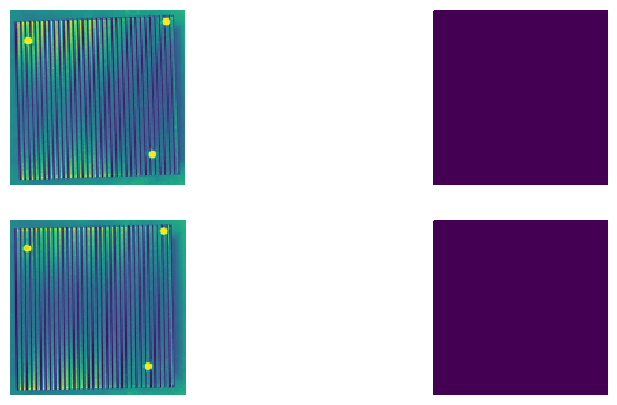

In [35]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 2,ncols = 2, figsize= (10,5))
for r in range(2):
    axes[r,0].set_axis_off()
    axes[r,1].set_axis_off()
    img_val = X_val[r].reshape((width,height))
    pred_val = np.array(decode_val[r]).reshape((width,height))
    axes[r,0].imshow(img_val,  interpolation = "nearest")
    axes[r,1].imshow(pred_val,  interpolation = "nearest")